# Single atom training
This notebook goes through the workflow of setting the hyperparameters, collecting atom manipulation data, and training the deep reinforcement learning agent.

### Importing modules

In [1]:
import sys
sys.path.append(r'D:\tys\Atom_manipulation_with_RL')
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from collections import deque, namedtuple
import torch
from AMRL import RealExpEnv, Episode_Memory, Createc_Controller, sac_agent, ReplayMemory, HerReplayMemory
from AMRL import plot_graph, show_reset, show_done, show_step
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Setting the anchor image
This cell retrieves the current STM scan image and use it as the template for positioning the anchor in STM images

succeed to connect


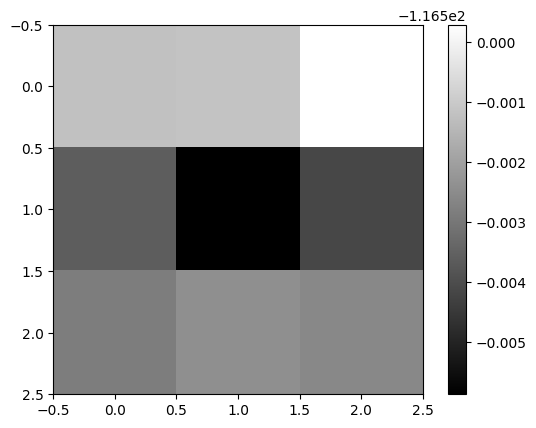

In [2]:
createc_controller = Createc_Controller(None, None, None, None)
img_forward = np.array(createc_controller.stm.scandata(1,4))
#TODO
#Set the pixel of the top-left corner, widht, and height of the anchor
#If the anchor is not used, just set w and h to a small number like below
top_left, w, h = (0,0), 3, 3
template = img_forward [top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
plt.imshow(template)
plt.colorbar()
# plt.scatter(top_left[0], top_left[1], marker='x', color='red')


### Set the parameters and create a RealExpEnv object

In [3]:
#TODO
step_nm = 0.4 #Set the radius of the manipulation start position relative the the atom start position
goal_nm  = 2 #Set the radius of the manipulation end position relative the the atom start position
max_mvolt = 15 #Set the maximum bias voltage in mV 
max_pcurrent_to_mvolt_ratio = 6E3 #Set the maximum conductance in pA/mV
max_len = 5 #Set maximum episode length
template_max_y = 3 #Set the maximum or minimum row number to search for anchor
#Set the path to load CNN weight for the atom movement classifier
CNN_weight_path = None
current_jump  = 4 #Set the current jump gradient/ std(current) threshold required to take STM scan

#Set STM scan parameters
pixel = 128 
im_size_nm = 25 #Image size in nm 
scan_mV = 2000 #bias voltage
x_nm, y_nm = createc_controller.get_offset_nm()
offset_nm = np.array([x_nm, y_nm]) #Set offset to current offset value

#Set manipulation parameters to pull atoms from image edge to center
pull_back_mV = 5 #bias in mV
pull_back_pA = 60000 #current in pA

#Set manipulation limit [left, right, up, down] in nm
manip_limit_nm = np.array([x_nm - 0.5*im_size_nm+0.25, x_nm + 0.5*im_size_nm-0.25, y_nm+0.25, y_nm+im_size_nm-0.25])

env = RealExpEnv(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 template, current_jump, im_size_nm, offset_nm, manip_limit_nm, pixel, 
                 template_max_y, scan_mV, max_len, 
                 CNN_weight_path, 
                 bottom=False, random_scan_rate = 0.8, pull_back_mV = pull_back_mV,
                 pull_back_pA = pull_back_pA)

succeed to connect


### Create a sac_agent object

In [4]:
#TODO
batch_size= 8 #Set minibatch size
LEARNING_RATE = 0.0003 #Set learning rate

#Set the action space range
ACTION_SPACE = namedtuple('ACTION_SPACE', ['high', 'low'])
action_space = ACTION_SPACE(high = torch.tensor([1,1,1,1,1,1]), low = torch.tensor([-1,-1,-1,-1,1/3,1/2]))

#Initialize the soft actor-critic agent
agent = sac_agent(num_inputs = 4, num_actions = 6, action_space = action_space, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=0.2)

### Create a HerReplayMemory object
Here we use the hindsight experience replay with the 'future' strategy to sample goals

In [5]:
#TODO
replay_size=1000000 #Set memory size

memory = HerReplayMemory(replay_size, env, strategy = 'future')

### Create a Episode_Memory object
The episode memory class is used to store all the relavant information in each training episode, including the STM images, state, action, reward, etc.

In [6]:
episode_memory = Episode_Memory()
#TODO
#Set the folder name to store training data and neural network weight
folder_name = r'D:\tys\scripts\AMRL' 

### Set the hyperparameters for Emphasize Recent Experience replay

In [7]:
c_k_min = 500
eta = 0.994
max_ep_len = max_len

### Create empty lists for logging performances

In [8]:
episode_rewards, alphas, precisions, episode_lengths = [], [], [], []
avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths = [], [], [], []

### Define the training function

In [9]:
def sac_train(max_steps = max_len, num_episodes = 50, episode_start = 0):
    """
    Collect training data and train the RL agent

    Parameters
    ----------
    max_steps: int
            maximum steps in an episode
            
    num_episodes: int
            Train for this many episodes
    
    episode_start: int
            Index to use for the starting episode

    Returns
    -------
    None : None
    """
    for i_episode in range(episode_start,episode_start+num_episodes):
        print('Episode:', i_episode)
        episode_reward, episode_steps = 0, 0
        done = False
        state, info = env.reset(update_conv_net=False)
        show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
                   env.template_nm, env.template_wh)
        episode_memory.update_memory_reset(env.img_info, i_episode, info)
        
        for step in range(max_steps):
            action = agent.select_action(state)
            old_atom_nm = env.atom_absolute_nm
            next_state, reward, done, info = env.step(action)
            episode_steps+=1
            episode_reward+=reward
            mask = float(not done)
            memory.push(state,action,reward,next_state,mask)
            episode_memory.update_memory_step(state, action, next_state, reward, done, info)
            show_step(env.img_info, info['start_nm']+old_atom_nm, info['end_nm']+old_atom_nm,
                        env.atom_absolute_nm, env.atom_start_absolute_nm, 
                        env.destination_absolute_nm, action[4]*env.max_mvolt, 
                        action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt, 
                        env.template_nm, env.template_wh)
            print('step:', step,'reward', reward, 'precision:', env.dist_destination)
            if done:
                episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
                episode_memory.save_memory(folder_name)
                print('Episode reward:', episode_reward)
                break
            else:                
                state=next_state
             
        if (len(memory)>batch_size):
            episode_K = int(episode_steps)
            for k in range(episode_K):
                c_k = max(int(memory.__len__()*eta**((k)*(1000/episode_K))), 500)
                agent.update_parameters(memory, batch_size, c_k)
        
        episode_rewards.append(episode_reward)
        alphas.append(agent.alpha.item())
        precisions.append(env.dist_destination)
        episode_lengths.append(episode_steps)
        avg_episode_rewards.append(np.mean(episode_rewards[-min(100,len(episode_rewards)):]))
        avg_alphas.append(np.mean(alphas[-min(100, len(alphas)):]))
        avg_precisions.append(np.mean(precisions[-min(100, len(precisions)):]))
        avg_episode_lengths.append(np.mean(episode_lengths[-min(100, len(episode_lengths)):]))
        
        if (i_episode+1)%2==0:
            plot_graph(episode_rewards, precisions, alphas, episode_lengths,
                      avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths)
            
        if (i_episode)%20 == 0:
            torch.save(agent.critic.state_dict(), '{}/_critic_{}.pth'.format(folder_name,i_episode))
            torch.save(agent.policy.state_dict(), '{}/_policy_{}.pth'.format(folder_name,i_episode))
            torch.save(agent.alpha, '{}/_alpha_{}.pth'.format(folder_name,i_episode))
            torch.save(env.atom_move_detector.conv.state_dict(), '{}/_atom_move_detector_conv_{}.pth'.format(folder_name,i_episode))

### Train the RL agent

Episode: 0
goal_nm: 0.4106277561576138


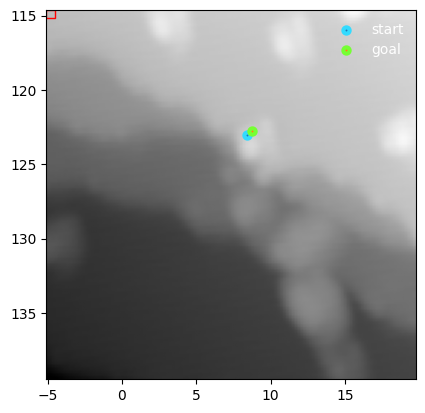

Prediction: 0.44148755
CNN prediction: 0.44148755 Old prediction: False
Random scan
The scan will take 110.1 seconds


IndexError: index 0 is out of bounds for axis 0 with size 0

In [11]:
sac_train(episode_start = 0,num_episodes = 1000)